In [1]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import cv2

import albumentations as A
import albumentations.pytorch

import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split

from jupyterthemes import jtplot
import warnings

#import functools

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    
set_random(42)

# Load data

In [4]:
cell_df = pd.read_csv('./sartorius-cell-instance-segmentation/train.csv')
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


id                                         annotation  width  \
65518  de504eaa5349  252178 6 252881 8 253585 9 254288 10 254992 11...    704   
48139  a76fe4d00355  112202 6 112905 10 113608 11 114314 9 115018 9...    704   
37042  836e5872684a  268741 3 269440 10 270138 18 270839 23 271544 ...    704   
60537  d09291445961  125348 8 126050 11 126753 13 127457 15 128162 ...    704   

       height cell_type plate_time sample_date  \
65518     520    shsy5y  11h30m00s  2019-06-15   
48139     520    shsy5y  11h30m00s  2019-06-14   
37042     520    shsy5y  11h30m00s  2019-06-14   
60537     520     astro  09h00m00s  2020-09-14   

                                sample_id elapsed_timedelta  
65518  shsy5y[diff]_D12-1_Vessel-714_Ph_2   0 days 11:30:00  
48139  shsy5y[diff]_E10-2_Vessel-714_Ph_3   0 days 11:30:00  
37042  shsy5y[diff]_D12-4_Vessel-714_Ph_4   0 days 11:30:00  
60537  astros[cereb]_F8-2_Vessel-361_Ph_4   0 days 09:00:00

In [5]:
TRAIN_DIR = Path('./sartorius-cell-instance-segmentation/train/')
TEST_DIR = Path('./sartorius-cell-instance-segmentation/test/')

In [6]:
train_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))

In [7]:
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


# Visualize the data

Create functions to make a mask based on annotations given in train.csv file

In [8]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [9]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width,3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height,width, 1))
    mask = mask.clip(0,1)
    return mask

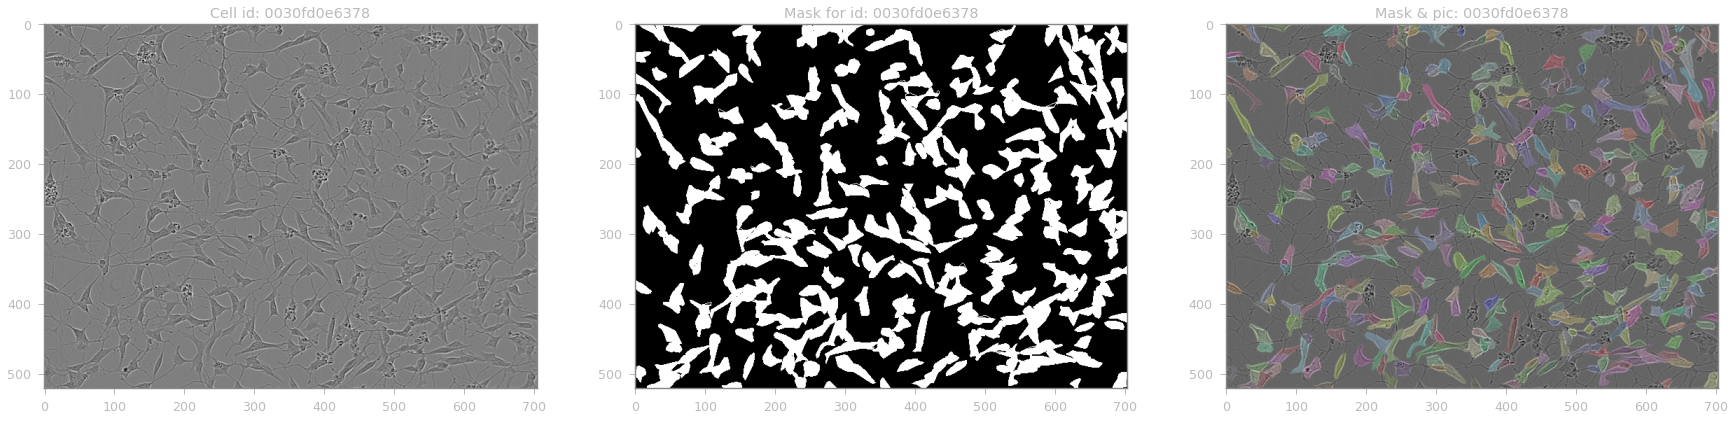

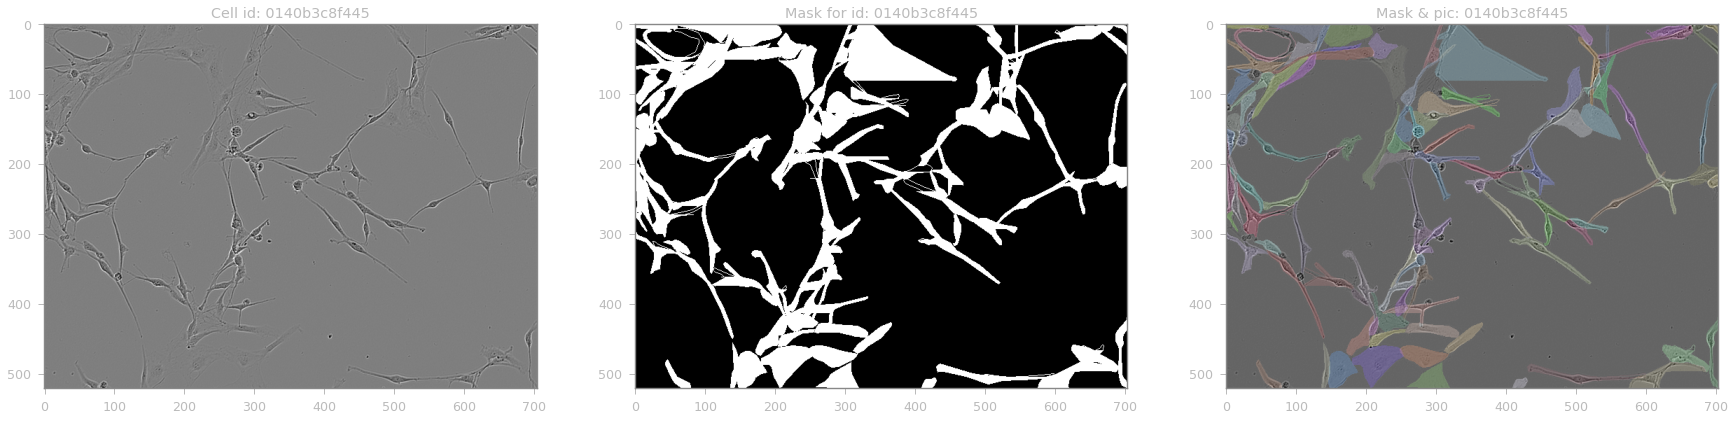

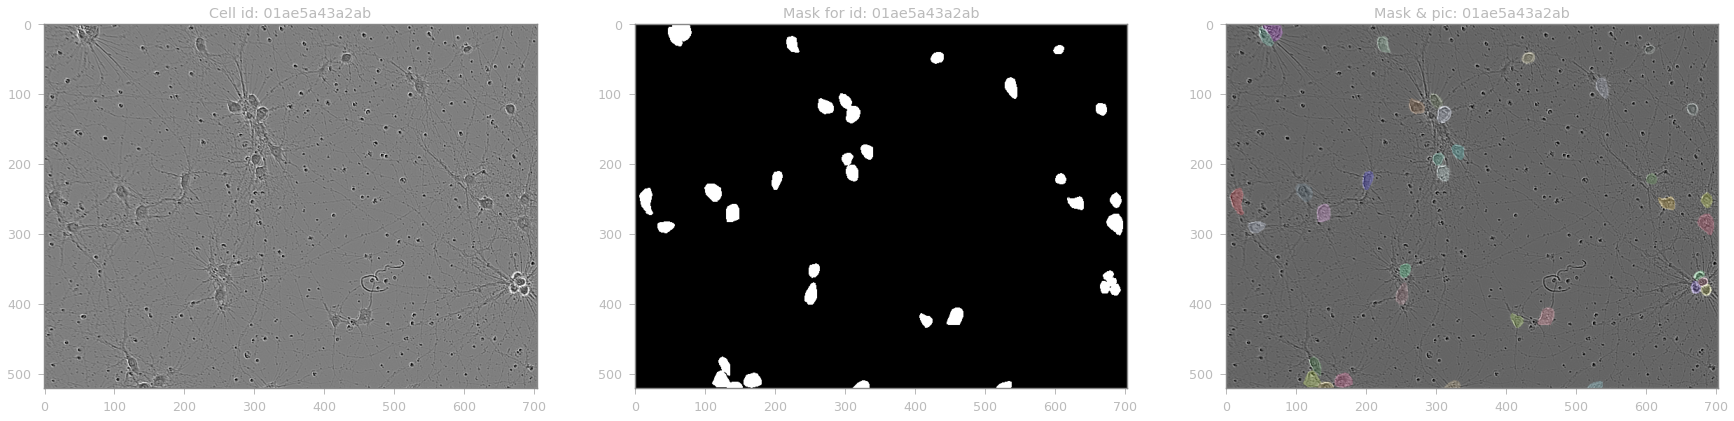

In [10]:
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    #label = (train_files[rand_idx]).name[:-4]
    label = (train_files[i]).stem#name[:-4]
    sample_im_df = cell_df[cell_df['id'] == label]
    sample_rles = sample_im_df['annotation'].values
    sample_masks1 = build_mask(sample_rles,input_shape=(520,704), colors=False)
    sample_masks2 = build_mask(sample_rles,input_shape=(520,704), colors=True)
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label))
    ax2.set_title('Mask for id: ' + str(label))
    ax3.set_title('Mask & pic: ' + str(label))
    plt.show();

Let's take a closer look to the second image. Seems something wrong with a mask

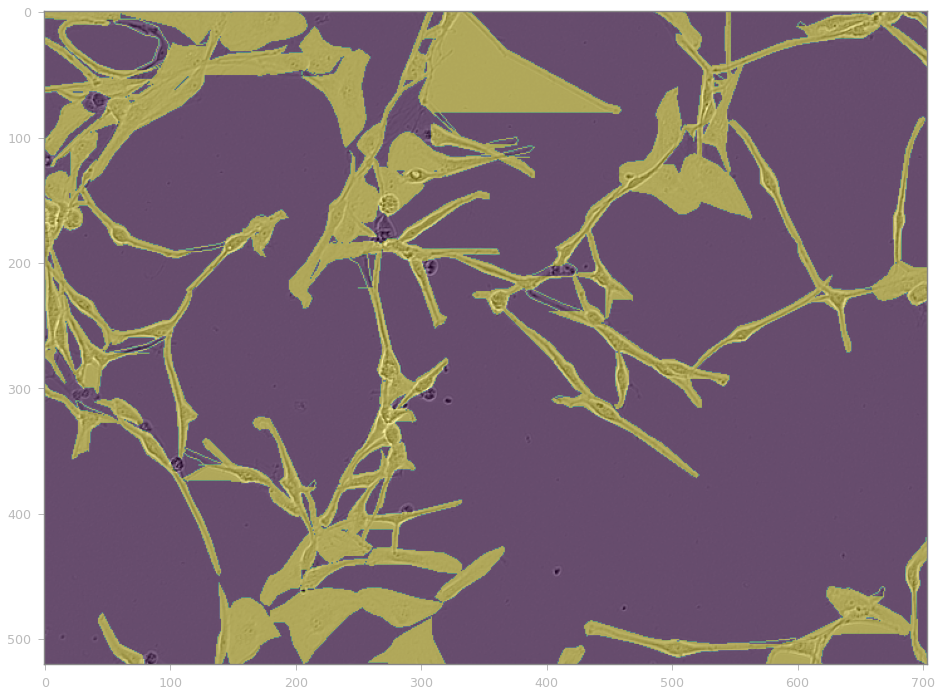

In [13]:
plt.figure(figsize=(16, 12))
im = PIL.Image.open(train_files[1])
label = (train_files[1]).stem#name[:-4]
sample_im_df = cell_df[cell_df['id'] == label]
sample_rles = sample_im_df['annotation'].values
mask = build_mask(sample_rles,input_shape=(520,704), colors=False)


plt.imshow(im,cmap='gray')
plt.imshow(mask,alpha = .4,);

Seems here we have an abnormally long continuous lines.

The mask is not representative enough.

We can take only correct masks to train our model.

**Thanks** [Slavko Prytula](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated#Utils)


In [14]:
TH = 30

def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

Re-write a function for building a masks, taking only not broken masks

In [15]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

Check the result

In [16]:
plt.figure(figsize=(16, 12))
mask = build_mask(sample_rles,input_shape=(520,704))

plt.imshow(im, cmap='gray')
plt.imshow(mask,alpha = .4);

# DataSets

## Define Dataset class

In [ ]:
# class NeuroDataSet(Dataset):
#     def __init__(self, files, df: pd.core.frame.DataFrame, train:bool, transform=None, use_cache=False):
#         super().__init__()
#         self.files = sorted(files)
#         self.df = df
#         self.gb = self.df.groupby('id')
#         self.transform = transform
#         self.cached_img = []
#         self.cached_mask = []
#         self.use_cache = use_cache
        
        
#         self.len_ = len(self.files)
    
#     def __len__(self):
#         return self.len_
    
#     def load_sample(self, file):
#         img = cv2.imread(str(file))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_id = file.stem
#         return img, img_id
    
#     def __getitem__(self, index):
        
#         if not self.use_cache:
#             # load image
#             image, image_id = self.load_sample(self.files[index])
#             annotation_df = self.gb.get_group(image_id)
#             #annotation = self.gb.get_group(self.files[index].stem)
#             #Create a mask
#             annotations = annotation_df['annotation'].values
#             mask = build_mask(annotations,input_shape=(520,704), colors=False)
            
#             if self.transform is not None and self.train:
#                 image = self.transform(image = image)["image"]
#                 mask = self.transform(image = mask)["image"]

#             self.cached_img.append(image)
#             self.cached_mask.append(mask)
#         else:
#             image = self.cached_img[index]
#             mask = self.cached_mask[index]
                                    
#         return image, mask
    
#     def set_use_cahe(self, use_cache):
#         if use_cache:
#             self.cached_img = torch.stack(self.cached_img)
#             self.cached_mask = torch.stack(self.cached_mask)
#         else:
#             self.cached_img = []
#             self.cached_mask = []
#         self.use_cache = use_cache

In [17]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame, train:bool, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.df = df
        self.gb = self.df.groupby('id')
        self.transform = transform      
        
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_
    
    #@functools.lru_cache(12)
    def load_sample(self, file):
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = np.expand_dims(img, axis=0)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self, index):
        
        # load image
        image, image_id = self.load_sample(self.files[index])
        annotation_df = self.gb.get_group(image_id)
        #annotation = self.gb.get_group(self.files[index].stem)
        #Create a mask
        annotations = annotation_df['annotation'].values
        mask = build_mask(annotations,input_shape=(520,704), colors=False)
        #mask = np.moveaxis(np.array(mask),2,0)
            
        if self.transform is not None:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            #mask = self.transform(image = mask)["image"]
        
        #image = np.expand_dims(image, axis=0)
        mask = np.moveaxis(np.array(mask),2,0)
        return image,mask

## Split train-val set

In [18]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.2)

In [19]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 484

Number of pictures in val set: 122


In [20]:
# split pandas dataframe with annotations for train df and val df
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 484

Number of picture's id in val set 122


## Augmentations

In [21]:
def get_augmentation(pic_size,train:bool):
    if train == False:
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.VerticalFlip(p=0.5)], p=0.5),
            A.OneOf([
                A.GaussNoise(),], p=1),
#             A.OneOf([
#                 A.MotionBlur(p=0.2),
#                 A.MedianBlur(blur_limit=3, p=0.1),
#                 A.Blur(blur_limit=3, p=0.1),], p=0.8),
#             A.ShiftScaleRotate(
#                 shift_limit=0.0625, 
#                 scale_limit=0.2, 
#                 rotate_limit=15, p=1),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.3),
#                 A.GridDistortion(p=0.1),], p=0.8),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.RandomBrightnessContrast(),], p=0.5),
#             A.HueSaturationValue(p=0.3),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train


## Data Loaders

In [22]:
BATCH_SIZE = 16

In [23]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,train=True,
                             transform=get_augmentation(224, train=True)
                            )

In [24]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12,) # pc -8 lap =4

In [25]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,
                           train=False,
                          transform=get_augmentation(224, train=False))

In [26]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12) # pc -8 lap =4

In [27]:
batch = next(iter(train_loader))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")

image shape: torch.Size([16, 3, 224, 224]),
mask shape:torch.Size([16, 1, 224, 224]),
batch len: 2


## Visualize Augmented DataSet

In [28]:
import copy

In [35]:
def visualize_augmentations(dataset, idx=1, samples=6, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

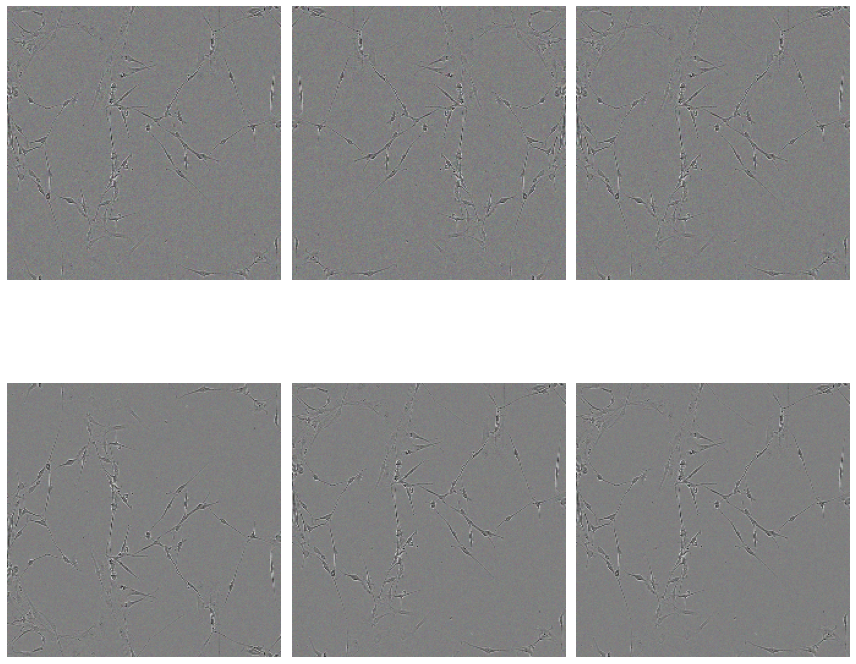

In [36]:
visualize_augmentations(train_dataset,idx=1)